# Team: SacSlicerII

## Members:
<b>1. 180030801</b> <br>
<b>2. 200006496</b> <br>
<b>3. 180016244</b> <br>
<b>4. 180014835</b> <br>
<b>5. 190004840</b> <br>
<b>6. 180003171</b> <br>

# 1.0 Data Exploration

We begin by examining the structure of the datasets present. Notably, we have two distinct datasets (further separated into testing and training sets). A summary of this information can be found in the following links:

1. https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203
2. https://www.kaggle.com/c/ieee-fraud-detection/data

## 1.1 Transaction Dataset
The following is a summary of the 393 features found in this dataset

| Feature | Type (overview) | Type (fine) | Description |
| --- | --- | --- | --- |
| TransactionID | Primary Key | int | 7 Digit Primary Key |
| TransactionDT | Quantitative | int | Timedelta Duration in Seconds |
| TransactionAMT | Quantitative | int | USD ($) Transaction Amount (to 3 decimals) |
| ProductCD | Categorical | str | Product Code of Transaction (single letter) |
| card{1,2,3,5} | Categorical | int? | Payment card information (numerical) |
| card{4,6} | Categorical | str | Payment card information (categorical) |
| addr{1,2} | Categorical | int | Purchaser address information |
| dist{1,2} | Quantitative | int? | Distance between addresses/IP's etc. |
| {P,R}_emaildomain | Categorical | str | Purchaser/recipient email domain |
| C{1-14} | Quantitative | int | Counting (context masked) |
| D{1-15} | Quantitative | int | Timedelta such as days between transactions |
| M{1-9} | Categorical | bool | Match such as names on cards, addresses, etc. |
| V{1-339} | Quantitative | int/float | Vesta engineered features (all numerical) |

## 1.2 Identity Dataset
The following is a summary of the 41 features found in this dataset

| Feature | Type (overview) | Type (fine) | Description |
| --- | --- | --- | --- |
| TransactionID | Primary Key | int | 7 Digit Primary Key |
| id-{01-11} | Quantitative | ? | Various identity features (numerical) |
| id-{12-38} | Categorical | ? | Various identity features (categorical) |
| DeviceType | Categorical | str | Mobile or desktop device type |
| DeviceInfo | Categorical | str | Device information (e.g. OS, model, etc.) |

___

# 2.0 Data initialization

## 2.1 Import libraries

In [1]:
import pandas as pd
import numpy as np

First, most of our data wrangling was inspired (although significantly different) from that found in the following link:
1. https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575

We performed a left join on the transaction and identity information since not all transactions have ID information, but we still had to predict for them anyway, and since some transactions in the identity dataset did not have corresponding `isFraud` entries.

## 2.2 Import the datsets

We imported the datasets and merged `transaction` and `identity` datasets for both `test` and `train`. We then removed any columns that had more than 90% NaN entries

In [2]:
# Import the necessary datasets 
data_train_t = pd.read_csv('ieee-fraud-detection/train_transaction.csv')
data_train_i = pd.read_csv('ieee-fraud-detection/train_identity.csv')
data_test_t = pd.read_csv('ieee-fraud-detection/test_transaction.csv')
data_test_i = pd.read_csv('ieee-fraud-detection/test_identity.csv')

In [3]:
# Merge the transaction and identity datasets together and drop columns with more than 90% NAs
train = pd.merge(data_train_t, data_train_i, how = 'left',on = 'TransactionID')
train.dropna(thresh = train.shape[0]*0.1, how = 'all', axis = 1, inplace = True)

# Remove transactionID from the training dataset
del train['TransactionID']

In [4]:
# Merge the transaction and identity datasets together and drop columns with more than 90% NAs
test = pd.merge(data_test_t, data_test_i, how = 'outer', on = 'TransactionID')

# Fix the name of the test columns by replacing '-' with '_'
test= test.rename(columns=lambda x:"_".join(x.split("-")))

___

# 3.0 Feature Engineering

## Type Correction

A key issue with unique counts is that integer values are being stored as floats, making it appear as if there are thousands of categories when in fact there are under 100. The most obvious example of this is observed in `addr2` which corresponds to countries. After converting this variable to a set, it claimed there were 65,780 unique values when in reality there are not nearly as many countries as this. Converting this variable to integers yielded 75 unique values instead.


Categorical variable number unique values excluding NaN (remove 1 from above results)

| Attribute | Unique Values | Numerical | Notes |
| --- | --- | --- | --- |
| ProductCD | 5 |  |
| card1 | 13552 | Yes | Likely card ID (ALREADY INT) |
| card2 | 500 | Yes | |
| card3 | 114 | Yes |  |
| card4 | 5 |  | Card provider |
| card5 | 119 | Yes |  |
| card6 | 5 |  | Credit, debit, etc. |
| addr1 | 332 | Yes | Billing region |
| addr2 | 74 | Yes | Billing Country |
| P_emaildomain | 59 |  | gmail.com, yahoo.com, etc. |
| R_emaildomain | 60 |  | gmail.com, yahoo.com, etc. |
| M{1-3, 5-9} | 3 | | Binary response (match or not) |
| M4 | 4 | | Trinary Response (M0, M1, or M2) |

Identity Table (not including NaN)
| Attribute | Unique Values | Numerical | Notes |
| --- | --- | --- | --- |
| DeviceType | 2 | | desktop, mobile |
| DeviceInfo | 1786 | | Freeform text entry (Windows, iOS Device, etc) |
| id_12 | 2 | | NotFound, Found |
| id_13 | 54 | Yes | |
| id_14 | 25 | Yes | |
| id_15 | 3 | | Found, New, Unknown (=/= NaN) |
| id_16 | 2 |  | Found, NotFound |
| id_17 | 104 | | Yes | |
| id_{19-20} | {522, 394} | Yes | |
| id_{28-29} | 2 | | Found, New/NotFound |
| id_30 | 75 | | OS (with ver numbers) |
| id_31 | 130 | | Browser OS |
| id_32 | 4 | Yes | Seems to be either 24 or 32 so basically binary |
| id_33 | 260 |  | Aspect ratio |
| id_34 | 4 |  |  |
| id_{35-38} | 2 | | Binary response |

None of the above columns were removed during the 90% NaN drop.



In [5]:
# Function mapping booleans to integers (nullable)
def mapper(input):
    trues = ['T', 'Found', 'desktop']
    falses = ['F', 'NotFound', 'New', 'mobile']

    if input in trues:
        return 1
    elif input in falses:
        return 0
    return input

In [6]:
# Make booleans binary
boolean_vars = ['DeviceType', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_16', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38']
train[boolean_vars] = train[boolean_vars].applymap(mapper)
test[boolean_vars] = test[boolean_vars].applymap(mapper)

## 3.1 Feature engineering with `DeviceInfo` 

`DeviceInfo` required the most specialised care as most values were simply `Windows` or `iOS` while Samsung and Android phones were split into more complex names, eg: `SM-G930V Build/NRD90M`. Before any encoding it was useful to try a version with engineering and one with direct frequency encoding to see which gave the best result. At the very least, grouping Samsung was likely to be interesting since it is a reputable brand.

In [7]:
# Samsung replace (Narrows ~500 Results)
train.loc[train['DeviceInfo'].fillna('None').str.contains('SM-'), 'DeviceInfo'] = 'SAMSUNG'
test.loc[test['DeviceInfo'].fillna('None').str.contains('SM-'), 'DeviceInfo'] = 'SAMSUNG'

## 3.2 Feature engineering with `TransactionDT`

The `TransctionDT` column allowed us to deduce the hour of the day, day of the week, and the time of day that a certain transaction occurred. This information was stored separately in new columns.

In [8]:
# Define a function that will allow us to add the relevant features

def new_vars1(train):
    train['Hourofday'] = np.floor((train['TransactionDT'] / (60*60))) % 24
    train['dayofweek'] = np.floor((train['TransactionDT'] / (60*60*24))) % 7
    train['TimeInDay'] = train['TransactionDT'] % 86400
    return train

# Run the function on the train and test dataset
train = new_vars1(train)
test = new_vars1(test)

## 3.3 Feature engineering with `id`

The id_33 column holds information on the screen width and height combined with an x. We split this into two seperate columns.

In [9]:
# Define a function that wil allow us to split features within a single column
def new_vars2(train):
    train['screen_width'] = pd.to_numeric(train['id_33'].str.split('x', expand=True)[0])
    train['screen_height'] = pd.to_numeric(train['id_33'].str.split('x', expand=True)[1])
    return train

# Run the function on the train and test dataset
train = new_vars2(train)
test = new_vars2(test)

## 3.4 Feature engineering with `card` and `addr` 

From the Kaggle discussion section, 
1. `card1` may be understood as an encoded column of unique card identities due to the high variety of unique values and the column being defined as a categorical feature by the host of the competition.
2. `card 2` will be assumed as the identity of bank/account as it represents a certain unique value of a transaction.
3. `addr1` may be assumed as the country of origin due to the small number of encoded categorical values in the feature, and the level of concentration for each unique value.
4. `addr2` may also be assumed as a county/state/province of the country as it holds a higher variety of unique categorical values with a higher value count for each unique value

Using this discussion we carried out the following to extract extra information:

1. We calculated how often certain values from the aforementioned columns appeared in the dataset

In [10]:
# Define a function to add features of unique value counts 
def new_vars3(train):
    temp = train['card1'].value_counts().to_dict()
    train['card1_counts'] = train['card1'].map(temp)
    temp = train['card1'].value_counts().to_dict()
    train['card2_counts'] = train['card1'].map(temp)
    temp = train['addr1'].value_counts().to_dict()
    train['addr1_counts'] = train['addr1'].map(temp)
    temp = train['addr2'].value_counts().to_dict()
    train['addr2_counts'] = train['addr2'].map(temp)
    return train

# Run the function on the train and test dataset
train = new_vars3(train)
test = new_vars3(test)

2. We calculated the mean value of the transaction done by a certain uniquely identifiable card/address

In [11]:
# Define a function to add features of the mean amount being transferred for certain unique card/location identities
def new_vars4(train):
    temp = train.groupby(['card1'])['TransactionAmt'].mean().to_dict()
    train['card1_mean'] = train['card1'].map(temp)
    temp = train.groupby(['card2'])['TransactionAmt'].mean().to_dict()
    train['card2_mean'] = train['card2'].map(temp)
    temp = train.groupby(['addr1'])['TransactionAmt'].mean().to_dict()
    train['addr1_mean'] = train['addr1'].map(temp)
    temp = train.groupby(['addr2'])['TransactionAmt'].mean().to_dict()
    train['addr2_mean'] = train['addr2'].map(temp)
    return train

# Run the function on the train and test dataset
train = new_vars4(train)
test = new_vars4(test)

3. We calculated the ratio of the mean of the transaction compared to the corresponding transaction amount 

In [12]:
# Define a function to add features of the ratio of certain transactions being made compared to the mean for each unique card/location identities
def new_vars5(train):
    train['card1_meanAMTratio'] = train['card1_mean']/train['TransactionAmt']
    train['card2_meanAMTratio'] = train['card2_mean']/train['TransactionAmt']
    train['addr1_meanAMTratio'] = train['addr1_mean']/train['TransactionAmt']
    train['addr2_meanAMTratio'] = train['addr2_mean']/train['TransactionAmt']
    return train

# Run the function on the train and test dataset
train = new_vars5(train)
test = new_vars5(test)

4. We calculated the standard deviation of the transactions for each unique card/location in order to assess how reguarly purchase habits are changing for each unique card/location

In [13]:
# Define a function to add features of the standard deviation of certain transactions 
def new_vars6(train):
    temp = train.groupby(['card1'])['TransactionAmt'].std().to_dict()
    train['card1_sd'] = train['card1'].map(temp)
    temp = train.groupby(['card2'])['TransactionAmt'].std().to_dict()
    train['card2_sd'] = train['card2'].map(temp)
    temp = train.groupby(['addr1'])['TransactionAmt'].std().to_dict()
    train['addr1_sd'] = train['addr1'].map(temp)
    temp = train.groupby(['addr2'])['TransactionAmt'].std().to_dict()
    train['addr2_sd'] = train['addr2'].map(temp)
    return train

# Run the function on the train and test dataset
train = new_vars6(train)
test = new_vars6(test)

## 3.5 Other miscellaneous feature engineering

We also added the following columns: one showing how many NAs are included in each row; one showing which transactions are recipients; and one extracting the cent value of all the transactions.

In [14]:
# Define a function to conduct the feature engineering
def new_vars7(train):
    train['isnotrecipient'] = train['R_emaildomain'].isna()
    train['numberna'] = train.isnull().sum(axis=1)
    train['cents'] = train['TransactionAmt'] % 1
    return train

# Run the function on the train and test dataset
train = new_vars7(train)
test = new_vars7(test)

___

# 4.0 Categorical Encoding

## Options

Frequency Encoding (FE), One Hot Encoding (OHE), and Ordinal Encoding (OE).
| Attribute | Unique Values | Strategy |
| --- | --- | --- |
| ProductCD | 5 | **OHE** |
| Card1 | 13552 | DROP or FE |
| Card2 | 500 | FE |
| Card3 | 114 | FE |
| Card4 | 5 | OHE |
| Card5 | 119 | FE |
| Card6 | 5 | OHE |
| addr1 | 332 | FE |
| addr2 | 74 | **OHE** |
| P_emaildomain | 59 | **FE** |
| R_emaildomain | 60 | **FE** |
| M{1-9} | 3-4 | **OHE** |
| --- | --- | --- |
| DeviceType | 2 | OHE |
| DeviceInfo | 1786 | FE (Engineered) |
| id_{12, 15-16, 28-29} | X | OHE |
| id_{13-14, 17, 19-20} | X | FE |
| id_30 | 75 | FE |
| id_31 | 130 | FE (Engineered) |
| id_32 | 4 | OHE |
| id_33 | 130 | FE |
| id_{34-38} | 2-4 | OHE |

We decided email domains may be better to one hot encode.

Boolean columns needed no encoding as they are already effectively numerical 

We then applied the specific encoding techniques to each of the fields:

1. One Hot Encoding
2. Frequency Encoding

In [15]:
# FREQUENCY ENCODING
def freq_encode(df, features):
    """
    Frequency encodes selected columns in-places

    features: List of frequency encoded feature names
    """
    for f in features:
        freqs = df[f].value_counts() / len(df) # Get frequencie
        df[f] = df[f].apply(lambda x: freqs[x] if pd.notna(x) else x) # Apply to values

# List of features to FE
FE_ids = [f'id_{x}' for x in [13,14,17,19,20,30,31,33]]
FE_vars = [
    'card1',
    'card2',
    'card3',
    'card5',
    'addr1',
    'P_emaildomain',
    'R_emaildomain',
    'DeviceInfo',
]
FE_vars.extend(FE_ids)

# Frequency Encode
freq_encode(train, FE_vars)
freq_encode(test, FE_vars)

In [16]:
# ONE HOT ENCODING (using no NaN imputation)
OHE_vars = [
    'ProductCD',
    'addr2',
    'card4',
    'card6',
    'M4',
    'id_15',
    'id_32',
    'id_34'
]

train = pd.get_dummies(train, columns=OHE_vars)
test = pd.get_dummies(test, columns = OHE_vars)

___

# 5.0 Fix to the testing dataset (Dummy variables, and other columns)

Due to the inconsistency between the unique categorical variables that exist between the training and testing datasets as a result of columns removed during the intial data wrangling of the training dataset with dummy columns being produced, we excluded dummy variables that only exist in the testing dataset and created a column of 0s in the testing dataset for dummy columns that only exist in the training set. Addtionally, we removed any extra columns in the test set.

In [17]:
# Correct the testing dataset 
only_train = set(train.columns) - set(test.columns) 
only_test = set(test.columns) - set(train.columns)
only_test.remove('TransactionID')
only_train.remove('isFraud')
test = test.drop(only_test,axis = 1)
for column in only_train:
    test[column] = 0

___

# 6.0 Model fitting

We downloaded the following necessary libraries to fit our models: XGBoostClassifer, HistGradientBoostingClassifier, and a LBMClassifier.

In [18]:
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
import multiprocessing
import lightgbm as gbm

C:\Users\mjf24\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\mjf24\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## 6.1 Fitting a XGBoostClassifier

We began by fitting an XGBoostClassifier. This step was initialized by defining the independent and response variables.

In [19]:
# Define independent and response variables
X = train.drop('isFraud', axis=1)
y = train['isFraud']

We took a smaller subsample of 15% in order to tune the hyperparameters

In [20]:
# Create a smaple to assess the accuracy score of the model 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.3, random_state = 30801)
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, train_size = 0.5, random_state = 30801)

We then carried out a grid search on max_depth, n_estimators, learning_rate, colsample_bytree, and subsample, to tune the hyperparameters, and used a 2-fold crossvalidation to find the ideal values that minimizes the generalisation error.

In [21]:
# XGB Regressor(Multi-threaded)
model = XGBClassifier(
    n_jobs = multiprocessing.cpu_count() // 2, # Use half of the available CPU
    use_label_encoder = False,
    eval_metric = 'logloss'
)

# Params
params = {
    'max_depth': [9], # 3 - 10
    'n_estimators': [700], # 100 - 1000
    'learning_rate': [0.3], # 0.01 - 0.3
    'colsample_bytree': [0.3], # 0.5 - 1
    'subsample': [1] # 0.6 - 1
}

clf1 = GridSearchCV(model, params, verbose=0, cv=2)
clf1.fit(X_train_sub, y_train_sub)
clf1.best_params_

C:\Users\mjf24\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\mjf24\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\mjf24\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


{'colsample_bytree': 0.3,
 'learning_rate': 0.3,
 'max_depth': 9,
 'n_estimators': 700,
 'subsample': 1}

### 6.1.1 Evaluating the model

To evaluate the model we calculated the AUC score, as this is the same metric used by Kaggle, as well as the accuracy score, the precision score, and the recall score in order to obtain relatively simple metrics for clients.

In [22]:
# Define optimal model
model = XGBClassifier(
    n_jobs = multiprocessing.cpu_count() // 2, # Use half of the available CPU
    use_label_encoder = False,
    eval_metric = 'logloss',
    max_depth = 9,
    n_estimators = 700,
    learning_rate = 0.04,
    colsample_bytree = 0.3
)

# Fit model to the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.04, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=2, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [23]:
# Fit the optimal model and create predictions for the validation data
y_prob_1 = model.predict_proba(X_test)
y_pred_1 = model.predict(X_test)

In [24]:
# Calculate the auc score
roc_auc_score(y_test, y_prob_1[:, 1])

0.9511223173129184

In [25]:
# Calculate the accuracy score
accuracy_score(y_test, y_pred_1)

0.9810560794236752

In [26]:
# Calculate the precision score
precision_score(y_test, y_pred_1, average = 'binary')

0.939314674339524

In [27]:
# Calculate the recall score
recall_score(y_test, y_pred_1, average = 'binary')

0.493642174719912

### 6.1.2 Variable importance

Plot the 10 most imoportant variables in the xgboost model

[Text(0.5, 1.0, '10 most important variables')]

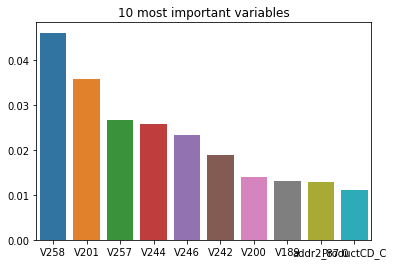

In [28]:
import seaborn as sns
variable_importance = [(X_train.columns[list(model.feature_importances_).index(i)],i) for i in 
sorted(model.feature_importances_, reverse = True)]
variable_importance
x_axis = []
y_axis = []
for i in range(10):
    x_axis.append(variable_importance[i][0])
    y_axis.append(variable_importance[i][1])
sns.barplot(x=x_axis,y=y_axis).set(title='10 most important variables')

### 6.1.3 Fit the model to the full train dataset

In [29]:
# Fit the model with the entire training set and 
model.fit(train.drop(['isFraud','TransactionDT'],axis=1),train['isFraud'])
y_pred_final_1 = model.predict_proba(test.drop(['TransactionID','TransactionDT'],axis=1))[:,1]

C:\Users\mjf24\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\mjf24\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [30]:
# Create a submissionable dataset
d_1 = {'TransactionID': test['TransactionID'], 'isFraud': y_pred_final_1}
df_1 = pd.DataFrame(data = d_1)

## 6.2 Fitting a HistGradientBoostingClassifier

Much like the XGBoostClassifier, we began by tuning the hyperparameters. This step was initiated by defining samples and subsamples. However, for this model the `TransactionDT` column was dropped as this has proved to create a better fit for this model. This was not surprising as the rows of the column are almost all unique from each other. Moreover, although HistGradientBoostingClassifer is capable of handling NA entries in the dataset, we imputed the null values with -1 as this improved the score of the model.

In [31]:
# Impute the training dataset 
with -1
X.fillna(-1)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,dist1,P_emaildomain,R_emaildomain,...,id_15_New,id_15_Unknown,id_32_0.0,id_32_16.0,id_32_24.0,id_32_32.0,id_34_match_status:-1,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2
0,86400,68.50,0.000073,-1.000000,0.882729,0.000469,0.039079,19.0,-1.000000,-1.0,...,0,0,0,0,0,0,0,0,0,0
1,86401,29.00,0.001157,0.005175,0.882729,0.049285,0.072393,-1.0,0.386688,-1.0,...,0,0,0,0,0,0,0,0,0,0
2,86469,59.00,0.001876,0.064593,0.882729,0.096759,0.044513,287.0,0.008629,-1.0,...,0,0,0,0,0,0,0,0,0,0
3,86499,50.00,0.007127,0.010392,0.882729,0.043928,0.016050,-1.0,0.170918,-1.0,...,0,0,0,0,0,0,0,0,0,0
4,86506,50.00,0.000030,0.024623,0.882729,0.049285,0.006064,-1.0,0.386688,-1.0,...,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,15811047,49.00,0.002003,-1.000000,0.882729,0.502161,0.034106,48.0,-1.000000,-1.0,...,0,0,0,0,0,0,0,0,0,0
590536,15811049,39.50,0.000020,0.012607,0.882729,0.138031,0.071155,-1.0,0.386688,-1.0,...,0,0,0,0,0,0,0,0,0,0
590537,15811079,30.95,0.001168,0.001243,0.882729,0.138031,0.012878,-1.0,0.386688,-1.0,...,0,0,0,0,0,0,0,0,0,0
590538,15811088,117.00,0.005090,0.010729,0.882729,0.138031,0.013864,3.0,0.047904,-1.0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Impute the training datset with -1
test.fillna(-1)

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,dist1,P_emaildomain,...,addr2_83.0,addr2_63.0,addr2_49.0,card6_debit or credit,addr2_92.0,addr2_35.0,addr2_21.0,addr2_14.0,addr2_23.0,id_32_0.0
0,3663549,18403224,31.950,0.000148,0.073706,0.859613,0.507195,0.003570,1.0,0.409417,...,0,0,0,0,0,0,0,0,0,0
1,3663550,18403263,49.000,0.001897,0.073706,0.859613,0.507195,0.076398,4.0,0.047461,...,0,0,0,0,0,0,0,0,0,0
2,3663551,18403310,171.000,0.000065,0.000150,0.859613,0.507195,0.014261,2635.0,0.079731,...,0,0,0,0,0,0,0,0,0,0
3,3663552,18403310,284.950,0.001656,0.022384,0.859613,0.090371,0.010460,17.0,0.409417,...,0,0,0,0,0,0,0,0,0,0
4,3663553,18403317,67.950,0.002402,0.002629,0.859613,0.041682,0.064556,6.0,0.409417,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679,0.004902,0.013191,0.105812,0.141301,0.002246,-1.0,0.409417,...,0,0,0,0,0,0,0,0,0,0
506687,4170236,34214287,12.173,0.009155,0.018054,0.105812,0.141301,-1.000000,-1.0,0.079731,...,0,0,0,0,0,0,0,0,0,0
506688,4170237,34214326,49.000,0.000989,0.063848,0.859613,0.507195,0.014760,-1.0,0.079731,...,0,0,0,0,0,0,0,0,0,0
506689,4170238,34214337,202.000,0.000008,0.000249,0.859613,0.141301,0.007804,-1.0,0.079731,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Create a subsample to tune hyperparameters
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.3, random_state = 30801)
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train.drop('TransactionDT', axis = 1), y_train, train_size = 0.4, random_state = 30801)

In [34]:
# Define a default model to conduct a grid searh
model = HistGradientBoostingClassifier(learning_rate = 0.1, max_leaf_nodes = 31)

# Define the grid of parameters we wish to search on
param_grid = {
    'learning_rate': [0.06], # [0.01, 0.02, 0.05, 0.06, 0.07, 0.1, 0.3, 0.4]
    'max_leaf_nodes' : [620], # [500, 550, 600, 610, 620, 650, 700, 800]
    'max_iter': [70] # [50, 60, 70, 80, 90, 100]
}

# Conduct a grid search and return the best values
clf2 = GridSearchCV(estimator = model, param_grid = param_grid, cv = 2, n_jobs = 4, verbose = 0)
clf2.fit(X_train_sub, y_train_sub)
clf2.best_params_

{'learning_rate': 0.06, 'max_iter': 70, 'max_leaf_nodes': 620}

### 6.2.1 Evaluating Accuracy of the model

Using the results from above fitted these hyperparameters to the model and evaluated using the same metrics previously mentioned.

In [35]:
# Fit model with tuned hyperparas
model = HistGradientBoostingClassifier(learning_rate = 0.06, max_leaf_nodes = 620, max_iter = 70)
model.fit(X_train, y_train)

HistGradientBoostingClassifier(learning_rate=0.06, max_iter=70,
                               max_leaf_nodes=620)

In [36]:
# Fit the optimal model and create predictions for the validation data
y_prob_2 = model.predict_proba(X_test)
y_pred_2 = model.predict(X_test)

In [37]:
# Calculate the auc score
roc_auc_score(y_test, y_prob_2[:,1])

0.9412369333362397

In [38]:
# Calculate the accuracy score
accuracy_score(y_test, y_pred_2)

0.9801997203528006

In [39]:
# Calculate the precision score
precision_score(y_test, y_pred_2, average = 'binary')

0.9272287862513426

In [40]:
# Calculate the recall score
recall_score(y_test, y_pred_2, average = 'binary')

0.4746717987490549

### 6.2.2 Fit the model to the full train dataset

In [41]:
# Define final model by fitting with tuned hyperparas and fit to the whole dataset
model.fit(train.drop(['isFraud', 'TransactionDT'], axis = 1), train['isFraud'])
y_pred_final_2 = model.predict_proba(test.drop(['TransactionID','TransactionDT'],axis=1))[:,1]

C:\Users\mjf24\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [42]:
# Create a submissionable dataset
d_2 = {'TransactionID': test['TransactionID'], 'isFraud': y_pred_final_2}
df_2 = pd.DataFrame(data = d_2)

## 6.3 Fitting a LGBMClassifier

In this section we fitted the dataset to a LGBMClassifier. Much like the HistGradientBoostingClassifier we dropped the `TransactionDT` column as it proved to be a better fit.  Again, we imputated -1 for NaN entries as this had a better performance score, despite the model being able to handle null values.

Before we began, we coverted float64, and int64 to float32 and int32 to decrease memory usage.

In [43]:
# Save memory usage in the training dataset
for col in train.columns:
    if train[col].dtype=='float64': train[col] = train[col].astype('float32')
    if train[col].dtype=='int64': train[col] = train[col].astype('int32')

In [44]:
# Save memory usage in the testing dataset
for col in test.columns:
    if test[col].dtype=='float64': test[col] = test[col].astype('float32')
    if test[col].dtype=='int64': test[col] = test[col].astype('int32')

Lightgbm cannot handle ':' in column names from the dummy variables so these were removed.

In [52]:
# Remove : in the training columns
for i in train.columns:
    if ':' in i:
        train.rename(columns = {i:i.replace(':', '') }, inplace = True)
for i in X_train.columns:
    if ':' in i:
        X_train.rename(columns = {i:i.replace(':', '') }, inplace = True)

# Remove : in the testing columns
for i in test.columns:
    if ':' in i:
        test.rename(columns = {i:i.replace(':', '') }, inplace = True)
for i in X_test.columns:
    if ':' in i:
        X_test.rename(columns = {i:i.replace(':', '') }, inplace = True)

Using optuna we were able to tune the best hyperparameters for this model and the hyperparameters were as shown below.

### 6.3.1 Evaluating Accuracy of the model

Using the results from above we fitted these hyperparameters to the model and evaluated using the same metrics.

In [53]:
# Fit model with the tuned hyperparas
model = gbm.LGBMClassifier(n_estimators = 1000,num_leaves = 4000 ,
                                    learning_rate = 0.016,min_child_samples = 100,
                           colsample_bytree = 0.5,
                                   random_state = 4840)
model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.016, min_child_samples=100,
               n_estimators=1000, num_leaves=4000, random_state=4840)

In [55]:
# Create predicted values with the fitted model
y_prob_3 = model.predict_proba(X_test)
y_pred_3 = model.predict(X_test)

In [56]:
# Calculate the auc score
roc_auc_score(y_test, y_prob_3[:,1])

0.9541142101433764

In [57]:
# Calculate the accuracy score
accuracy_score(y_test, y_pred_3)

0.9830010305337972

In [58]:
# Calculate the precision score
precision_score(y_test, y_pred_3, average = 'binary')

0.9565428502063608

In [59]:
# Calculate the recall score
recall_score(y_test, y_pred_3, average = 'binary')

0.5416179806172245

### 6.3.2 Fit the model to the full train dataset

In [60]:
# Fit the model with the whole dataset and make prediction values
model.fit(train.drop(['isFraud','TransactionDT'],axis=1),train['isFraud'])
y_pred_final_3= model.predict_proba(test.drop(['TransactionID','TransactionDT'],axis=1))[:,1]

In [61]:
# Create a submissionable dataset
d_3 = {'TransactionID': test['TransactionID'], 'isFraud': y_pred_final_3}
df_3 = pd.DataFrame(data = d_3)

___

# 7.0 Final fitting

Our final model is an ensemble of all three models with weights based on the AUC score obtained from our Kaggle public score.

## 7.1 Evaluate Ensemble

We used the same evaluations to assess the quality of the model.

In [62]:
# Create an ensemble model using the results
ensemble = (y_pred_1*0.923 + y_pred_2*0.929 + y_pred_3*0.93)/(0.923 + 0.929 + 0.93)
ensemble_prob = (y_prob_1*0.923 + y_prob_2*0.929 + y_prob_3*0.93)/(0.923 + 0.929 + 0.93)

In [63]:
#Round the ensemble predictions to the binary domain of integers [0, 1]
y_pred_4 = np.rint(ensemble)

In [64]:
# Calculate the auc score
roc_auc_score(y_test, ensemble_prob[:,1])

0.952197808241645

In [65]:
# Calculate the accuracy score
accuracy_score(y_test, y_pred_4)

0.9816294045643454

In [66]:
# Calculate the precision score
precision_score(y_test, y_pred_4, average = 'binary')

0.9481891996391287

In [67]:
# Calculate the recall score
recall_score(y_test, y_pred_4, average = 'binary')

0.5056704928173757

## 7.2 Fit final ensemble

Again, our final model was fitted using the aforementioned method involving the weights to create an ensemble model. 

In [68]:
# Create a column of the isFraud results and calculate the weighted values
ensemble_res = (df_1['isFraud']*0.923 + df_2['isFraud']*0.929 + df_3['isFraud']*0.93)/(0.923+0.929+0.93)

In [69]:
# Create a dataset of the final ensemble results
d_4 = {'TransactionID': test['TransactionID'], 'isFraud': ensemble_res}
df_4 = pd.DataFrame(data = d_4)

In [70]:
# Create a submissable file and export it to a seperate csv file
df_4.to_csv('Final_sub.csv', index = False)